##### Copyright 2019 The TensorFlow Hub Authors.
Licensed under the Apache License, Version 2.0 (the "License");

Created by @[Adrish Dey](https://github.com/captain-pool) for [Google Summer of Code](https://summerofcode.withgoogle.com/) 2019

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS, 
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Image Super Resolution using ESRGAN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/image_enhancing"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/image_enhancing.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/image_enhancing.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/image_enhancing.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/captain-pool/esrgan-tf2/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

This colab demonstrates use of TensorFlow Hub Module for Enhanced Super Resolution Generative Adversarial Network (*by Xintao Wang et.al.*) [[Paper](https://arxiv.org/pdf/1809.00219.pdf)] [[Code](https://github.com/captain-pool/GSOC/)]

for image enhancing. *(Preferrably bicubically downsampled images).*

Model trained on DIV2K Dataset (on bicubically downsampled images) on image patches of size 128 x 128.

**Preparing Environment**

In [2]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [3]:
!wget "https://user-images.githubusercontent.com/12981474/40157448-eff91f06-5953-11e8-9a37-f6b5693fa03f.png" -O original.png

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [14]:
# Declaring Constants
IMAGE_PATH = "C:/Users/user/Desktop/Age and Gender/orginal.png"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

**Defining Helper Functions**

In [5]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [6]:
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

#### Performing Super Resolution of images loaded from path

In [16]:
hr_image = preprocess_image(IMAGE_PATH)

Saved as Original Image.jpg


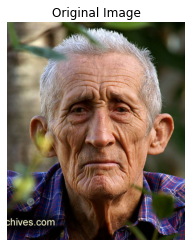

In [17]:
# Plotting Original Resolution image
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image")

In [33]:
model = hub.load(SAVED_MODEL_PATH)
# generator = tf.keras.models.Sequential([
#     hub.KerasLayer("https://tfhub.dev/captain-pool/esrgan-tf2/1", trainable=True),
#     tf.keras.layers.Conv2D(filters=3, kernel_size=[1, 1], strides=[1, 1])])

In [32]:
# generator.build([None, 256, 256, 3])

# generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1024, 1024, 3)     4605955   
                                                                 
 conv2d (Conv2D)             (None, 1024, 1024, 3)     12        
                                                                 
Total params: 4,605,967
Trainable params: 4,605,967
Non-trainable params: 0
_________________________________________________________________


In [24]:
model = tf.keras.models.load_model("super_resol.model")

In [26]:
for layer in model.layers:
    layer.trainable =False
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 sequential_12 (Sequential)     (None, 32, 32, 128)  3584        ['input_2[0][0]']                
                                                                                                  
 sequential_13 (Sequential)     (None, 16, 16, 128)  147584      ['sequential_12[0][0]']          
                                                                                                  
 sequential_14 (Sequential)     (None, 8, 8, 256)    296192      ['sequential_13[0][0]']          
                                                                                            

In [19]:
start = time.time()
fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 11.792352


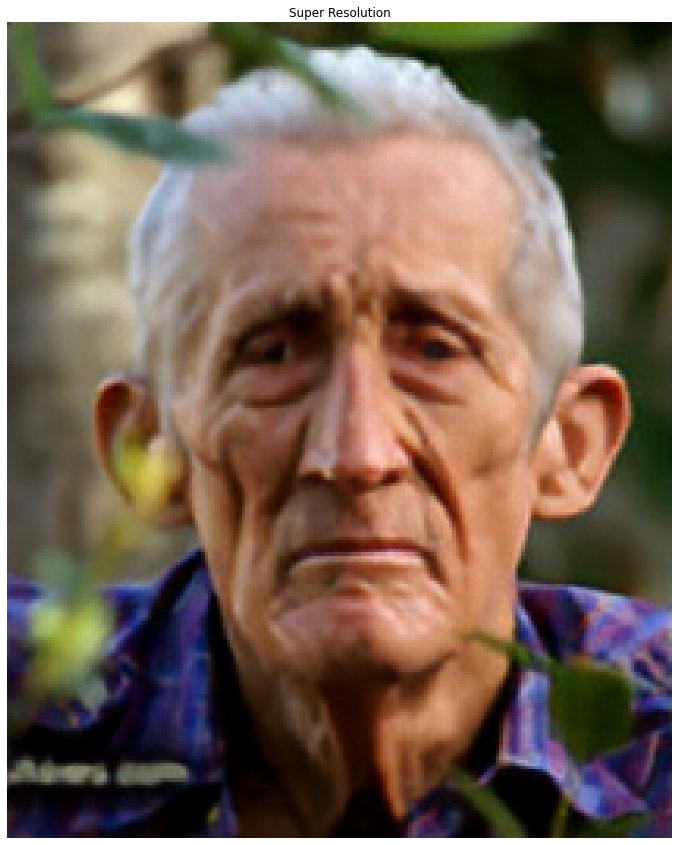

In [77]:
# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image), title="Super Resolution")
#save_image(tf.squeeze(fake_image), filename="Super Resolution")

### Evaluating Performance of the Model

In [ ]:
!wget "https://lh4.googleusercontent.com/-Anmw5df4gj0/AAAAAAAAAAI/AAAAAAAAAAc/6HxU8XFLnQE/photo.jpg64" -O test.jpg
IMAGE_PATH = "test.jpg"

In [44]:
# Defining helper functions
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] //8 , image_size[1] // 8],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [45]:
hr_image = preprocess_image(IMAGE_PATH)


In [54]:
lr_image = downscale_image(tf.squeeze(hr_image))


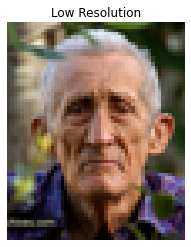

In [47]:
# Plotting Low Resolution Image
plot_image(tf.squeeze(lr_image), title="Low Resolution")

In [48]:
model = hub.load(SAVED_MODEL_PATH)

In [72]:
start = time.time()
fake_image1 = model(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 0.294213


InvalidArgumentError: {{function_node __wrapped__SquaredDifference_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [260,212,3] vs. [1,524,428,3] [Op:SquaredDifference]

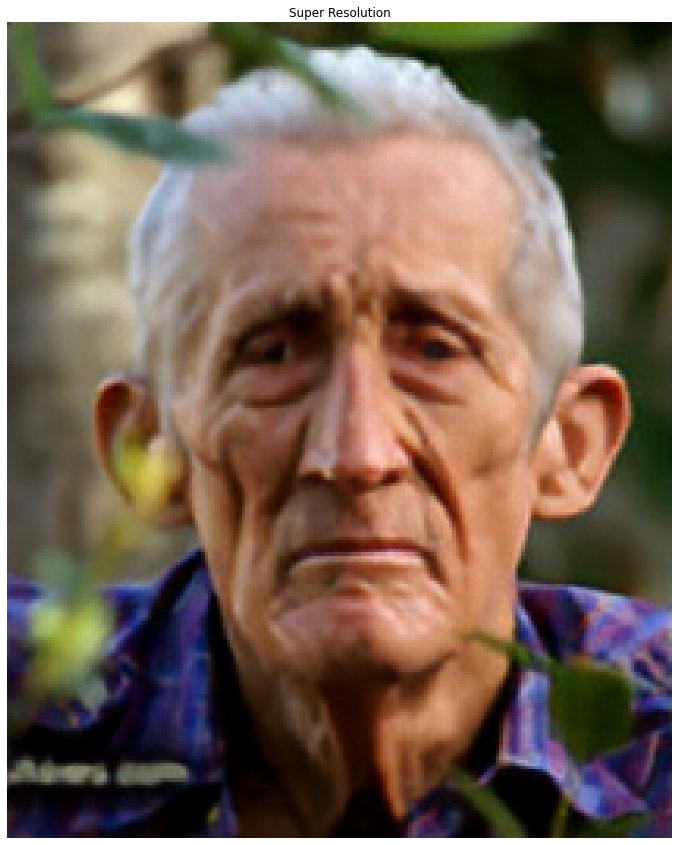

In [73]:
plot_image(tf.squeeze(fake_image1), title="Super Resolution")
# Calculating PSNR wrt Original Image
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)

**Comparing Outputs size by side.**

PSNR: 25.552542


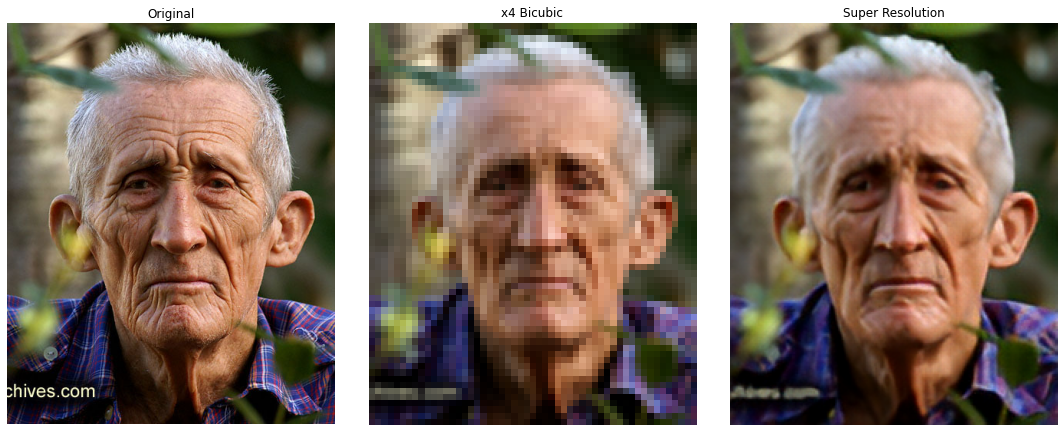

In [56]:
plt.rcParams['figure.figsize'] = [15, 15]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "x4 Bicubic")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")
print("PSNR: %f" % psnr)

In [58]:
from tensorflow.keras.models import load_model
m1 = load_model("high_resol1.model")
m2 = load_model("high_resol2.model")

In [60]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
import os
from tqdm import tqdm
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential
import keras
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from tensorflow.keras.utils import img_to_array

In [64]:
i = cv2.imread("orginal.png")
i=cv2.cvtColor(i1, cv2.COLOR_BGR2RGB)
res_i=cv2.resize(i,(64,64))
res_i = res_i.astype('float32') / 255.0
img =img_to_array(res_i)

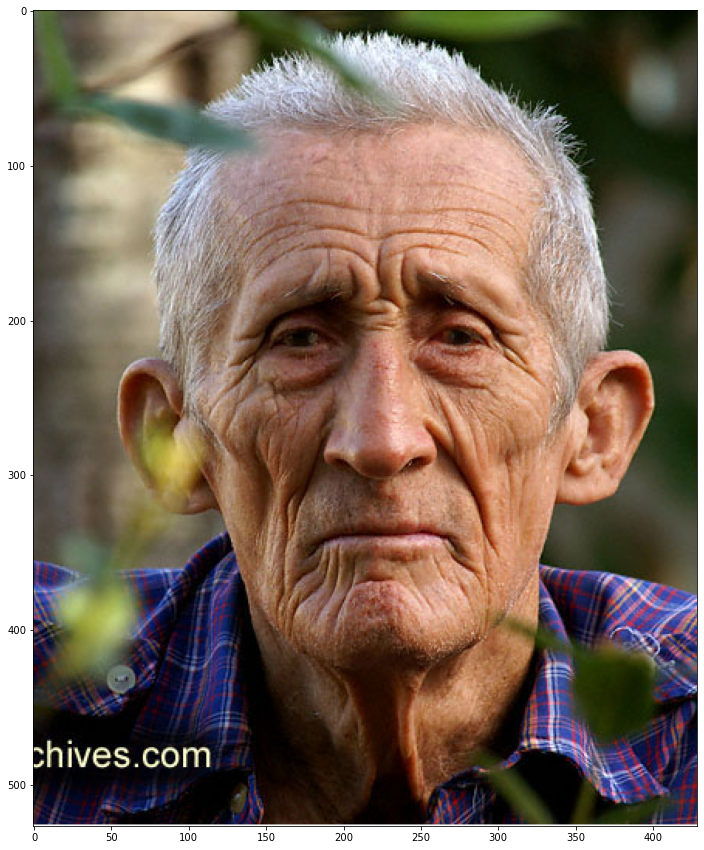

In [70]:
plt.imshow(i)

In [69]:
SIZE = 64
HSIZE =256
predicted1 = np.clip(m1.predict(img.reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(HSIZE, HSIZE,3)
predicted2 = np.clip(m2.predict(predicted1.reshape(1,HSIZE, HSIZE,3)),0.0,1.0).reshape(HSIZE, HSIZE,3)

1/1 [==============================] - 0s 187ms/step


In [76]:
def plot_images(high,low,predicted2,predicted3):
    plt.figure(figsize=(15,15))
    plt.subplot(1,4,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,4,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,4,3)
    plt.title('esrgan prediction ', color = 'Red', fontsize = 20)
    plt.imshow(predicted1)
    plt.subplot(1,4,4)
    plt.title('my model prediction', color = 'blue', fontsize = 20)
    plt.imshow(predicted3)
   
    
    plt.show()
plot_images(i,img,predicted2,image)

TypeError: Cannot handle this data type: (1, 1, 212, 3), |u1